In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
%aimport beanmachine.ppl

In [14]:
%autoreload

In [157]:
import beanmachine.ppl as bm
import torch
import torch.distributions as dist
import torch.optim as optim

from beanmachine.ppl.inference.variational.variational_infer import (
    kl_forward,
    kl_reverse,
    monte_carlo_approximate_reparam,
    monte_carlo_approximate_sf,
)

sigma_0 = 1.0

class NormalNormal:
    def __init__(self):
        self.device = 'cpu'

    @bm.random_variable
    def mu(self):
        return dist.Normal(
            torch.zeros(1).to(self.device), sigma_0 * torch.ones(1).to(self.device)
        )

    @bm.random_variable
    def x(self, i):
        return dist.Normal(self.mu(), torch.ones(1).to(self.device))

model = NormalNormal()

@bm.param
def phi():
    return torch.zeros(2)

@bm.random_variable
def q_mu():
    params = phi()
    return dist.Normal(params[0], torch.nn.functional.softplus(params[1]))

obs = {
    model.x(i): 5+torch.randn((1,))
    for i in range(5)
}
world = bm.VariationalInfer().infer(
    queries_to_guides={model.mu(): q_mu()},
    observations=obs,
    num_steps=100,
    num_samples=5,
    optimizer=lambda params: optim.Adam(params, lr=1e-1),
    discrepancy_fn=kl_reverse,
    #discrepancy_fn=kl_forward,
    mc_approx=monte_carlo_approximate_reparam,
    #mc_approx=monte_carlo_approximate_sf,
)
world.get_variable(q_mu()).distribution

  0%|          | 0/100 [00:00<?, ?it/s]

Normal(loc: 4.735093593597412, scale: 0.3820481300354004)

In [158]:
true_posterior = dist.Normal(
    loc=sum(obs.values()) / (len(obs) + 1),
    scale=1 / (1 + len(obs))
)

In [159]:
nuts_samples = bm.GlobalNoUTurnSampler().infer(
    [model.mu()],
    obs,
    num_samples=100,
    num_chains=1,
)

Samples collected:   0%|          | 0/150 [00:00<?, ?it/s]

/root/micromamba/lib/python3.9/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/root/micromamba/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


[-3.0, 7.0]

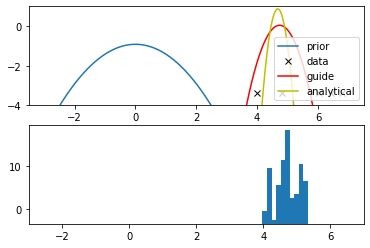

In [160]:
import matplotlib.pyplot as plt
import numpy as np

xs = torch.linspace(-3, 7, steps=1000)
prior = dist.Normal(0, sigma_0).log_prob(xs)
guide = world.get_variable(q_mu()).distribution.log_prob(xs).detach().numpy()

fig = plt.figure()
ax = fig.add_subplot(211)

ax.set_ylim([-4,1])
ax.plot(xs, prior)
ax.plot(obs.values(), np.zeros(len(obs.values()))-3.4, 'kx')
ax.plot(xs, guide, 'r')
ax.plot(xs, true_posterior.log_prob(xs), 'y')
ax.legend(['prior', 'data', 'guide', 'analytical'])

ax = fig.add_subplot(212)
ax.hist(nuts_samples.get_chain(0)[model.mu()].detach().numpy(), bottom=-3.4)

plt.setp(ax, xlim=[-3,7])